In [ ]:
import os

mgf_file = "/mnt/data/cdens/casanovo-scaling/massivekb_data/massiveKB_3cac03860ff7453a821332ab4cff20f4.mgf"
cache_dir = "massiveKB_3cac0386"
os.makedirs(cache_dir, exist_ok=True)

In [9]:
# from analysis import create_sub_mgf

# Create the sub file and set the mgf file to the sub mgf
# mgf_file = create_sub_mgf(mgf_file, cache_dir, num_spectra=10000)

In [30]:
from analysis import create_sequence_index

df = create_sequence_index(mgf_file, cache_dir)

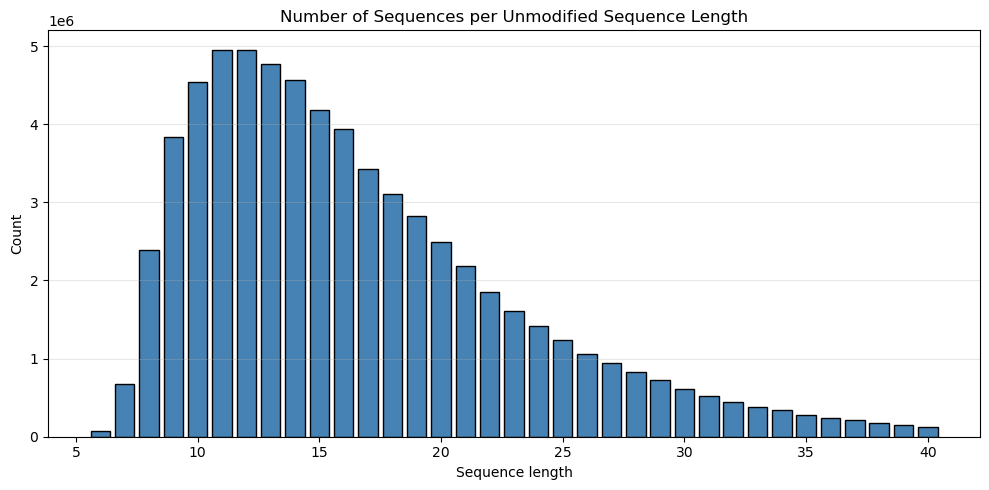

In [31]:
import matplotlib.pyplot as plt

# Compute sequence lengths
df["seq_length"] = df["unmodified_sequence"].str.len()

# Count occurrences of each length
length_counts = df["seq_length"].value_counts().sort_index()

# Plot as a bar chart
plt.figure(figsize=(10, 5))
plt.bar(length_counts.index, length_counts.values, color="steelblue", edgecolor="black")

plt.title("Number of Sequences per Unmodified Sequence Length")
plt.xlabel("Sequence length")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

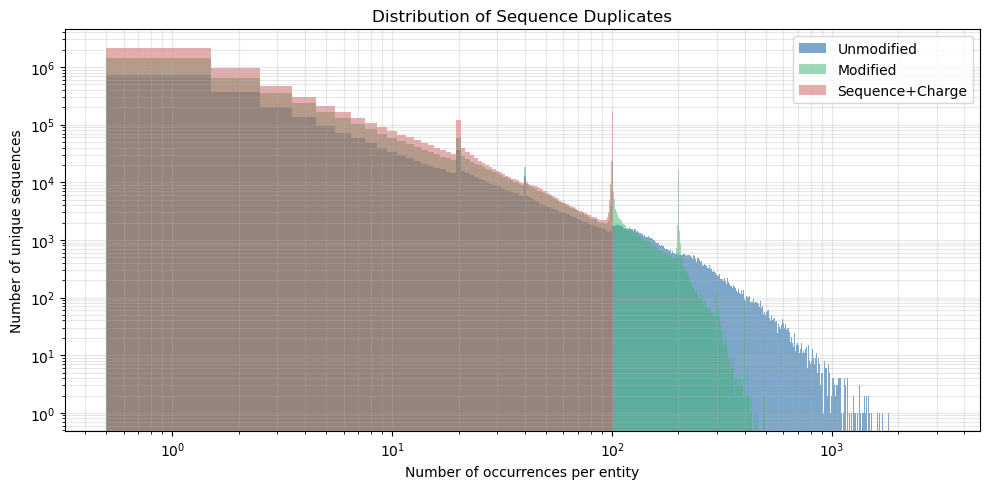

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Count duplicates as before
unmod_counts = df["unmodified_sequence"].value_counts()
mod_counts = df["sequence"].value_counts()
seq_charge = df["sequence"].astype(str) + "_" + df["charge"].astype(str)
seq_charge_counts = seq_charge.value_counts()

# 2️⃣ Count how many sequences appear N times (frequency of frequencies)
unmod_dist = unmod_counts.value_counts().sort_index()
mod_dist = mod_counts.value_counts().sort_index()
seq_charge_dist = seq_charge_counts.value_counts().sort_index()

# 3️⃣ Combine x-values to align all distributions
all_x = sorted(set(unmod_dist.index) | set(mod_dist.index) | set(seq_charge_dist.index))
unmod_y = [unmod_dist.get(x, 0) for x in all_x]
mod_y = [mod_dist.get(x, 0) for x in all_x]
seq_charge_y = [seq_charge_dist.get(x, 0) for x in all_x]

# 4️⃣ Plot as overlapping bars
plt.figure(figsize=(10, 5))
plt.bar(all_x, unmod_y, width=1.0, label="Unmodified", alpha=0.7, color="steelblue")
plt.bar(all_x, mod_y, width=1.0, label="Modified", alpha=0.5, color="mediumseagreen")
plt.bar(all_x, seq_charge_y, width=1.0, label="Sequence+Charge", alpha=0.5, color="indianred")

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of occurrences per entity")
plt.ylabel("Number of unique sequences")
plt.title("Distribution of Sequence Duplicates")
plt.legend()
plt.grid(which="both", alpha=0.3)
plt.tight_layout()
plt.show()

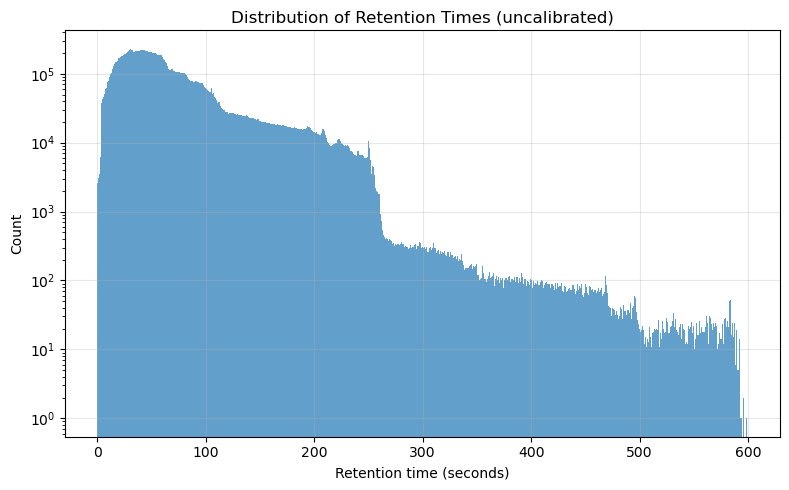

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df[df["rt"] < 600]["rt"], bins='auto', alpha=0.7)
plt.title("Distribution of Retention Times (uncalibrated)")
plt.xlabel("Retention time (seconds)")
plt.ylabel("Count")
plt.yscale("log")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

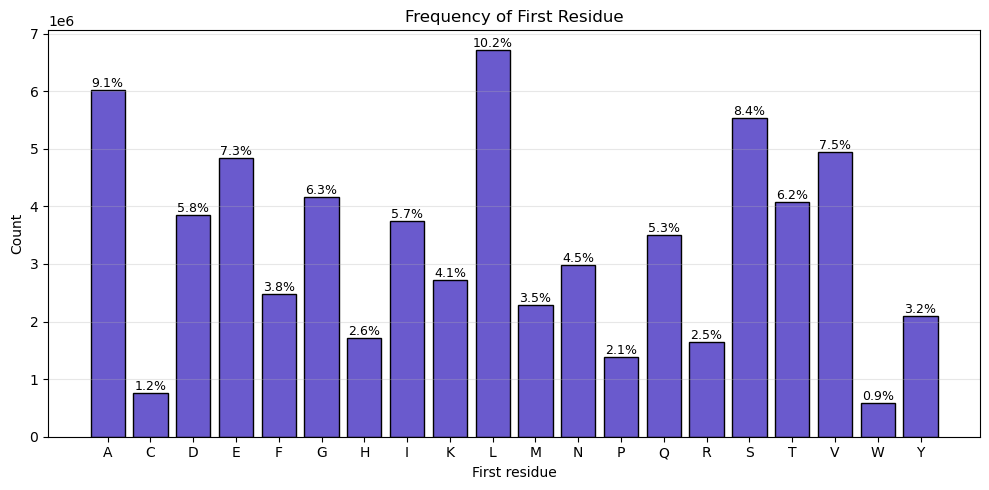

In [57]:
# Count how often each residue appears
first_res_counts = df["unmodified_sequence"].dropna().str[0].value_counts().sort_index()

total = first_res_counts.sum()
percentages = 100 * first_res_counts / total

# Plot as a bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(first_res_counts.index, first_res_counts.values, color="slateblue", edgecolor="black")

# Annotate bars with percentages
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{pct:.1f}%",
             ha='center', va='bottom', fontsize=9, rotation=0)

plt.title("Frequency of First Residue")
plt.xlabel("First residue")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

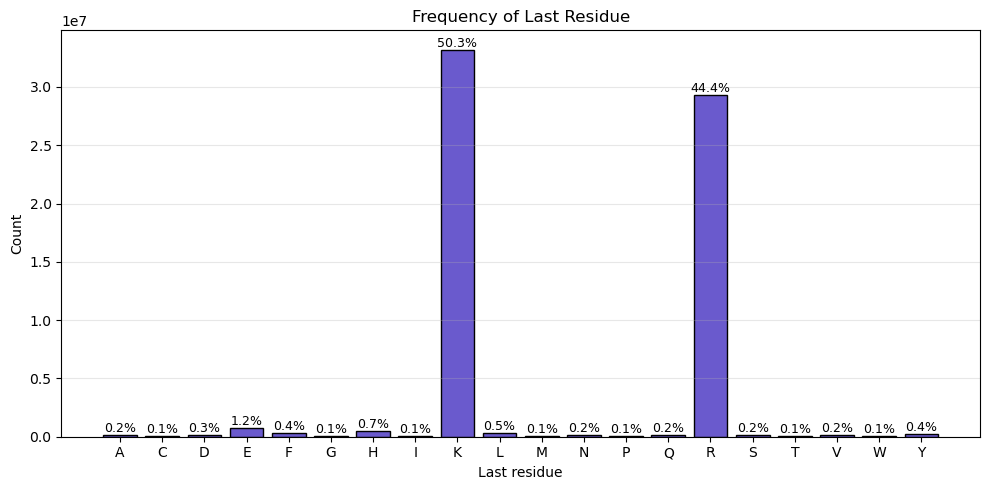

In [58]:
# Count how often each residue appears
last_res_counts = df["unmodified_sequence"].dropna().str[-1].value_counts().sort_index()

total = last_res_counts.sum()
percentages = 100 * last_res_counts / total

# Plot as a bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(first_res_counts.index, last_res_counts.values, color="slateblue", edgecolor="black")

# Annotate bars with percentages
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{pct:.1f}%",
             ha='center', va='bottom', fontsize=9, rotation=0)

plt.title("Frequency of Last Residue")
plt.xlabel("Last residue")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

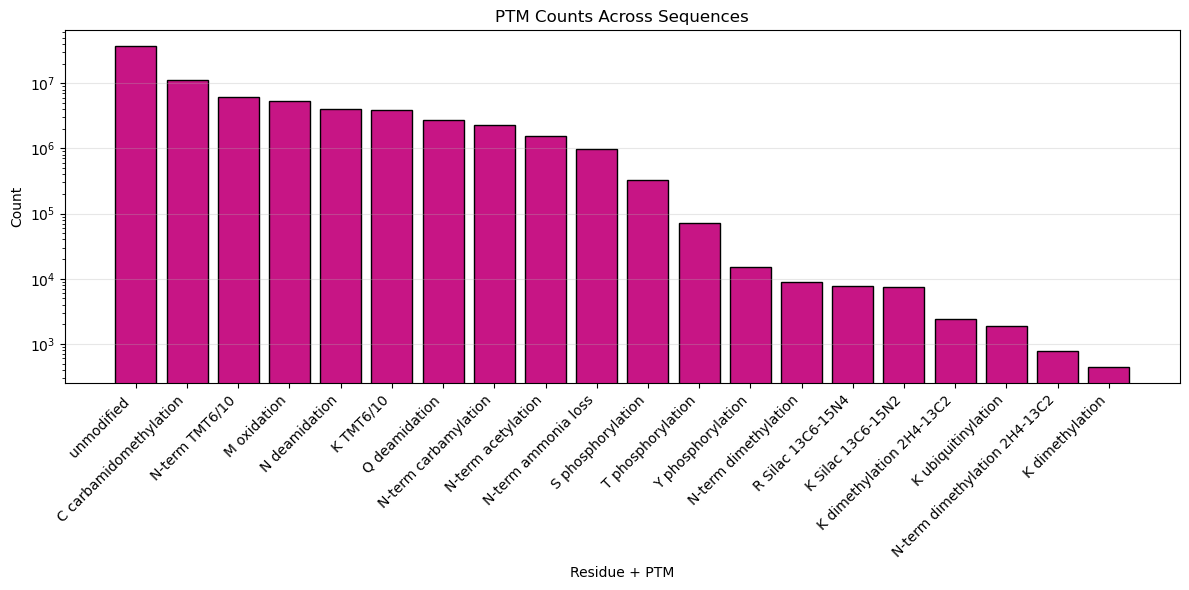

In [65]:
import re
from collections import Counter

# SOME PTM STATS
extracted = []
for seq, unmod_seq in zip(df["sequence"], df["unmodified_sequence"]):
    matches = re.findall(r'([A-Z]?)([+-]?\d+\.\d+)', seq)

    if not matches or seq == unmod_seq:  # either no PTM or identical to unmodified
        extracted.append(("unmodified", ""))
        continue

    # get unique (residue, ptm) pairs for this sequence
    unique_pairs = set()
    for residue, ptm in matches:
        if residue == "":
            residue = "N-term"
        unique_pairs.add((residue, ptm))

    extracted.extend(unique_pairs)

mod_count = Counter(extracted)

ptm_dict = {
    '+0.984': 'deamidation',
    '+57.021': 'carbamidomethylation',
    '+15.995': 'oxidation',
    '+42.011': 'acetylation',
    '+43.006': 'carbamylation',
    '-17.027': 'ammonia loss',
    '+79.966': 'phosphorylation',
    '+28.031': 'dimethylation',
    '+10.008': 'Silac 13C6-15N4',
    '+8.014': 'Silac 13C6-15N2',
    '+34.063': 'dimethylation 2H4-13C2',
    '+114.043': 'ubiquitinylation',
    '+229.163': 'TMT6/10',
}

# Convert mod_count to use readable PTM names
mod_count_named = Counter()
for (residue, ptm), count in mod_count.items():
    ptm_name = ptm_dict.get(ptm, ptm)  # fallback to original if not in dict
    mod_count_named[(residue, ptm_name)] = count

# Convert Counter to lists for plotting
labels, counts = zip(*mod_count_named.items())
labels = [f"{residue} {ptm}" for residue, ptm in labels]  # e.g., "N deamidation"

# Optional: sort by count descending
counts, labels = zip(*sorted(zip(counts, labels), reverse=True))

plt.figure(figsize=(12, 6))
plt.bar(labels, counts, color="mediumvioletred", edgecolor="black")
plt.yscale("log")  # optional: useful if counts vary widely
plt.xticks(rotation=45, ha="right")
plt.xlabel("Residue + PTM")
plt.ylabel("Count")
plt.title("PTM Counts Across Sequences")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

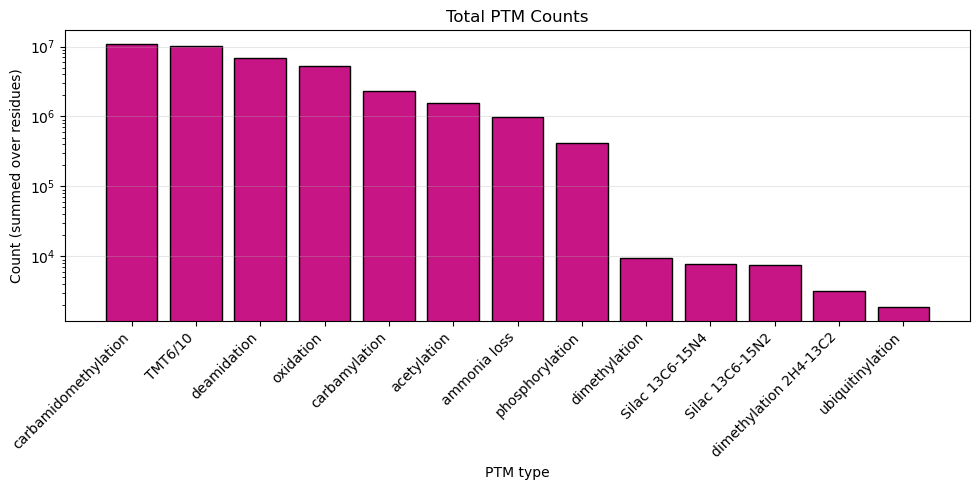

In [67]:
ptm_counts = Counter()
for (residue, ptm), count in mod_count_named.items():
    if residue == "unmodified":
        continue  # skip unmodified sequences
    ptm_counts[ptm] += count

# 2️⃣ Prepare for plotting
labels, counts = zip(*sorted(ptm_counts.items(), key=lambda x: x[1], reverse=True))

# 3️⃣ Plot
plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color="mediumvioletred", edgecolor="black")
plt.yscale("log")  # optional
plt.xticks(rotation=45, ha="right")
plt.xlabel("PTM type")
plt.ylabel("Count (summed over residues)")
plt.title("Total PTM Counts")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()